# Visualise GRACE data:

In [1]:
import matplotlib.pyplot as plt

from grace.io.image_dataset import ImageGraphDataset
from grace.evaluation.process import generate_ground_truth_graph
from grace.evaluation.visualisation import (
    display_image_and_grace_annotation, 
    read_patch_stack_by_label, 
    montage_from_image_patches, 
    overlay_from_image_patches,
    plot_simple_graph,
    plot_connected_components
)

/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Visualise the overlay of annotated graph on image annotation mask:

In [19]:
import torch
from grace.models.feature_extractor import FeatureExtractor

In [20]:
bbox_size = (224, 224)
extractor_filename = "/Users/kulicna/Desktop/classifier/extractor/resnet152.pt"
pre_trained_resnet = torch.load(extractor_filename)
feature_extractor = FeatureExtractor(model=pre_trained_resnet, bbox_size=bbox_size)


In [21]:
grace_path = "/Users/kulicna/Desktop/dataset/shape_stars/infer"
dataset = ImageGraphDataset(
    image_dir=grace_path, 
    grace_dir=grace_path, 
    transform=feature_extractor,
)
image, graph_data = dataset[0]
graph = graph_data["graph"]
graph.number_of_nodes(), graph.number_of_edges()


09/18/2023 04:31:07 PM MRC_Synthetic_File_006
09/18/2023 04:31:07 PM Nodes count | [56, 96, 37] x | [29.63, 50.79, 19.58] %
09/18/2023 04:31:07 PM Edges count | [246, 111, 195] x | [44.57, 20.11, 35.33] %
09/18/2023 04:31:07 PM Relabelled 'Annotation.UNKNOWN'
09/18/2023 04:31:07 PM Nodes count | [93, 96, 0] x | [49.21, 50.79, 0.0] %
09/18/2023 04:31:07 PM Edges count | [441, 111, 0] x | [79.89, 20.11, 0.0] %
/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialia

(189, 552)

### Generate ground truth graph:

In [22]:
gt_graph = generate_ground_truth_graph(graph)
gt_graph.number_of_nodes(), gt_graph.number_of_edges()


(189, 111)

### Display the annotation:

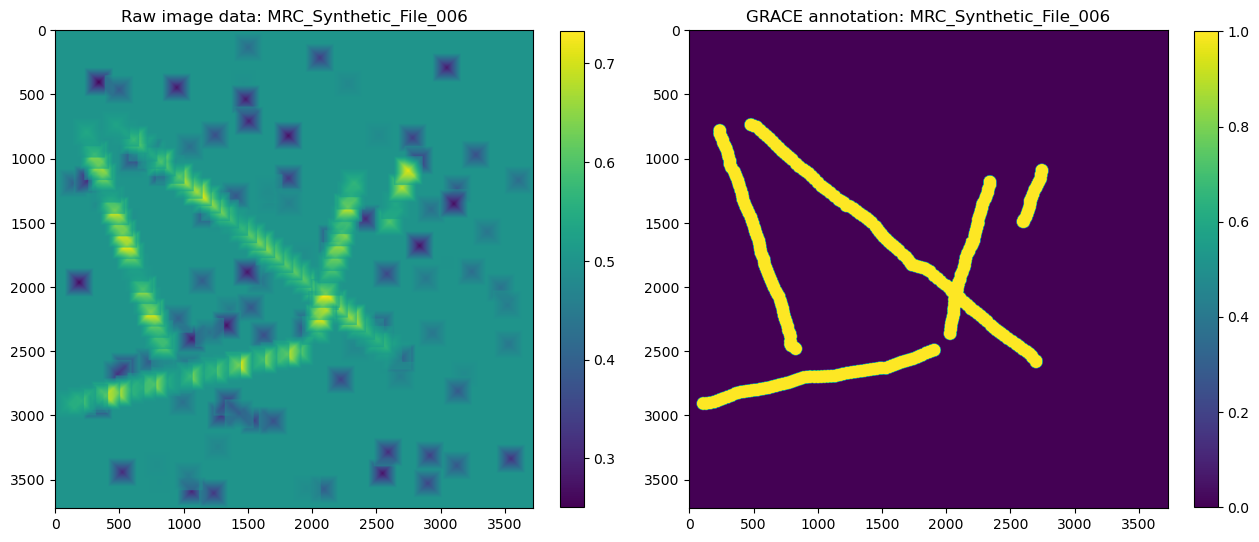

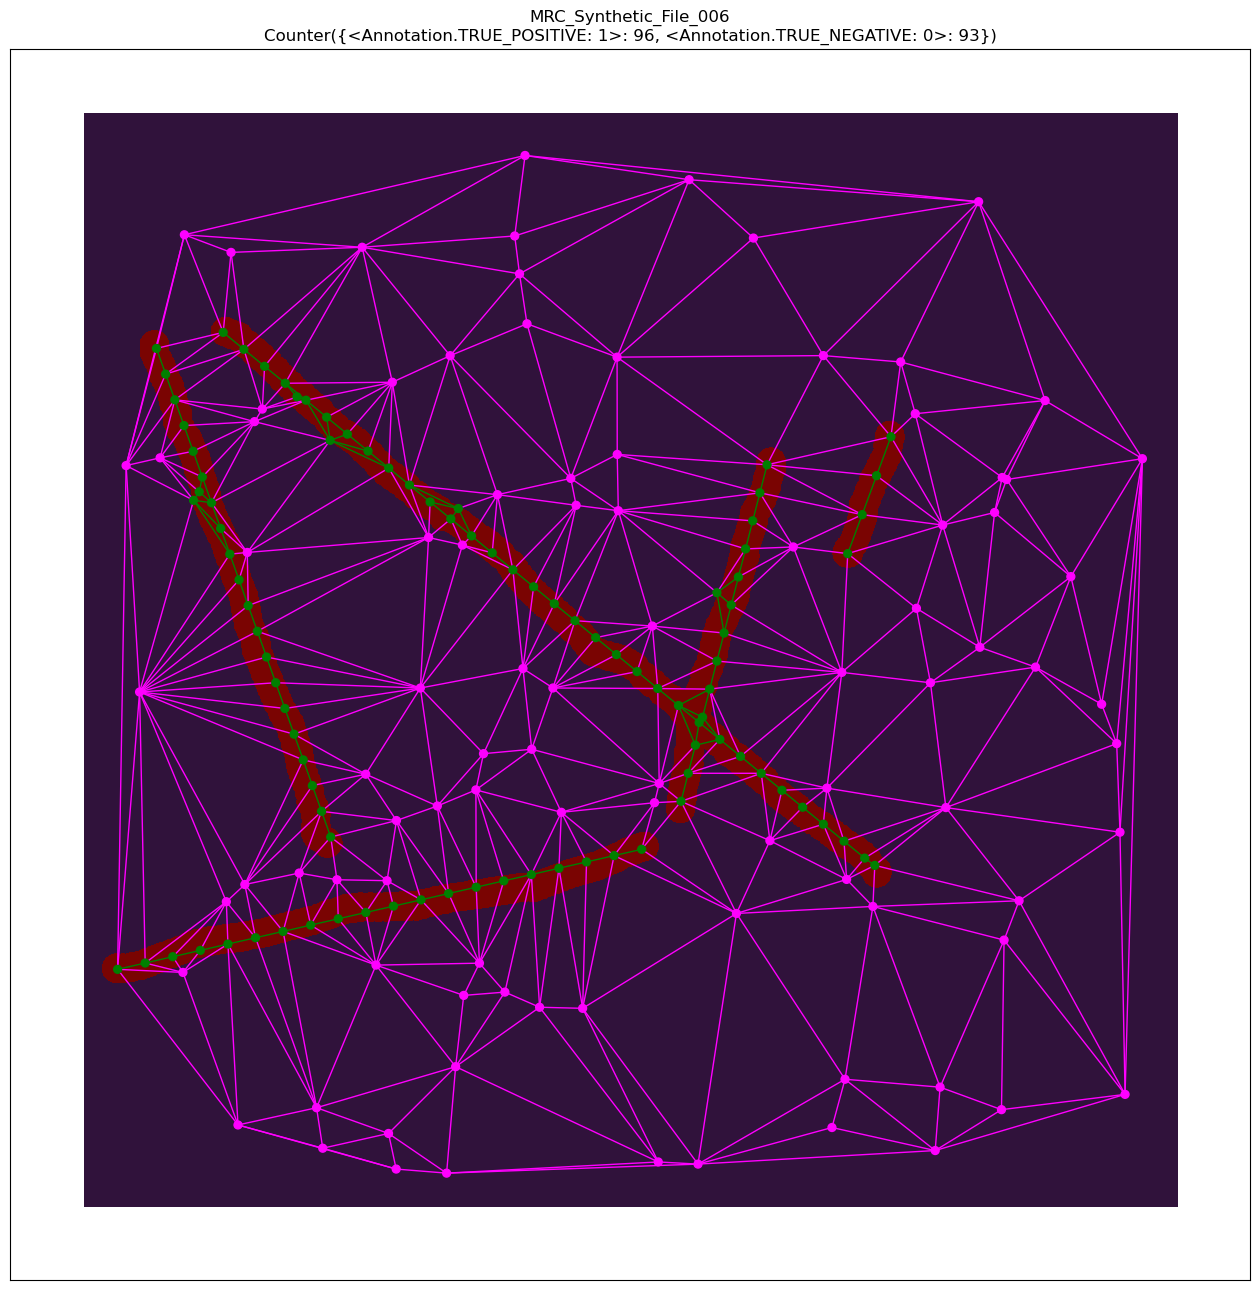

In [23]:
display_image_and_grace_annotation(image=image, target=graph_data)

### Visualise the crops montages & overlay:

In [24]:
crops = read_patch_stack_by_label(G=graph_data["graph"], image=image, crop_shape=bbox_size)
[len(c) for c in crops]

[93, 96, 0]

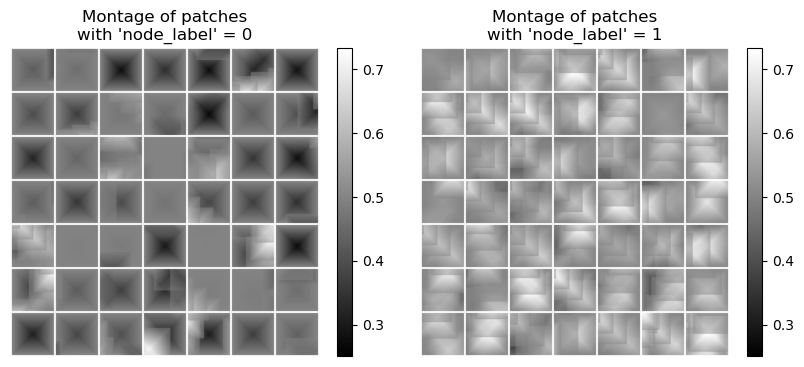

In [25]:
montage_from_image_patches(crops)

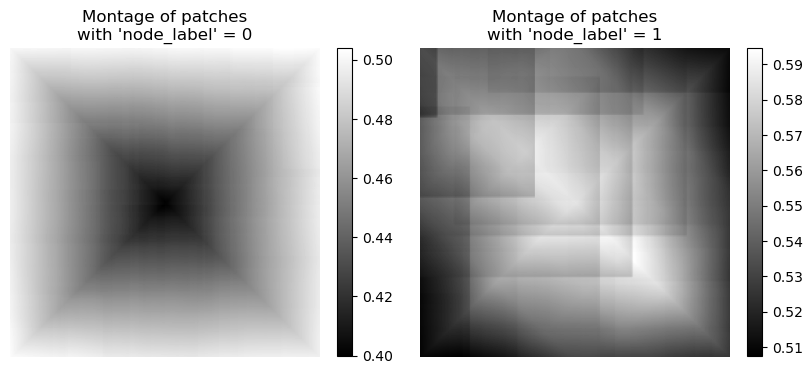

In [26]:
overlay_from_image_patches(crops)

### Draw the plain graphs:

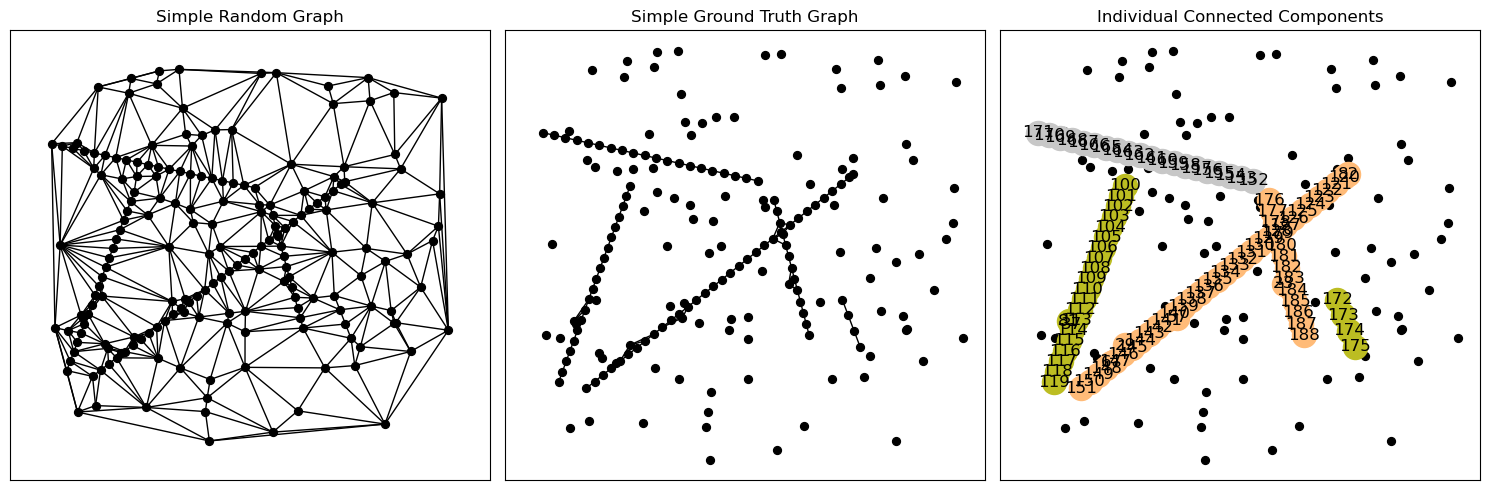

In [27]:
shape = 5
_, axes = plt.subplots(1, 3, figsize=(shape*3, shape*1))

plot_simple_graph(graph, title=f"Simple Random Graph", ax=axes[0])
plot_simple_graph(gt_graph, title=f"Simple Ground Truth Graph", ax=axes[1])
plot_connected_components(gt_graph, title=f"Individual Connected Components", ax=axes[2])

plt.tight_layout()
plt.show()


##### Done!

In [153]:
import numpy as np
import networkx as nx
import matplotlib
import torch_geometric

from grace.models.datasets import dataset_from_graph
# from torch_geometric.data import Data
from grace.base import Annotation

In [154]:
graph.nodes(data=True)[0]

{<GraphAttrs.NODE_X: 'x'>: 1062.1717529296875,
 <GraphAttrs.NODE_Y: 'y'>: 3594.8076171875,
 <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: nan,
 <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.TRUE_NEGATIVE: 0>,
 <GraphAttrs.NODE_FEATURES: 'features'>: tensor([0.8016, 0.4302, 0.8573,  ..., 0.3967, 0.3314, 0.3832])}

In [155]:
dataset = dataset_from_graph(graph, mode='sub', in_train_mode=True)
len(dataset), type(dataset[0])

(189, torch_geometric.data.data.Data)

In [184]:
COLOR_MAPPING = {
    0 : "dodgerblue", # "magenta", 
    1 : "firebrick", # "green", 
    2 : "grey"
}


In [193]:
def plot_subgraph_geometry(
    sub_graph: torch_geometric.data.Data, 
    *,
    title: str = "",
    color_mapping: dict[int, str] = None,
    ax: matplotlib.axes = None,
) -> matplotlib.axes:
    
    # Extract data from subgraph:
    pos = sub_graph.edge_attr.numpy()
    node_GT_labels = sub_graph.y.numpy()
    edge_GT_labels = sub_graph.edge_label.tolist()
    edge_indices = sub_graph.edge_index.numpy()
    assert pos.shape[0] == len(node_GT_labels)
    assert edge_indices.shape[-1] == len(edge_GT_labels)
    
    # Define color mapping & plot:
    color_mapping = color_mapping if color_mapping is not None else COLOR_MAPPING

    # Plot the edges underneath:
    for e_idx in range(edge_indices.shape[-1]):
        src, dst = edge_indices[:, e_idx]
        st, en = pos[src], pos[dst]
        true_color = color_mapping[edge_GT_labels[e_idx]]
        ax.plot([st[0], en[0]], [st[1], en[1]], lw=5, ls="solid", c=true_color)  # true

        # TODO: implement this:
        pd = np.random.randint(2)
        pred_style = "dashed" if pd == 0 else "solid"
        ax.plot([st[0], en[0]], [st[1], en[1]], lw=2, ls=pred_style, c="black")  # pred
        
    # Plot the scatter on top:
    title = f"Subgraph Geometry\n{title}"
    node_color = [color_mapping[GT] for GT in node_GT_labels]
    node_style = ["solid" if np.random.randint(2) == 0 else "dashed" for _ in range(len(node_GT_labels))]

    ax.scatter(x=pos[:, 0], y=pos[:, 1], s=200, c=node_color, ls=node_style, linewidths=2, edgecolors="k", zorder=edge_indices.shape[-1]+1)
    ax.set_title(title)
    
    [ax.scatter(x=[], y=[], c=color_mapping[i], label=f"Label '{i}'") for i in range(len(color_mapping))]
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(color_mapping))
    return ax

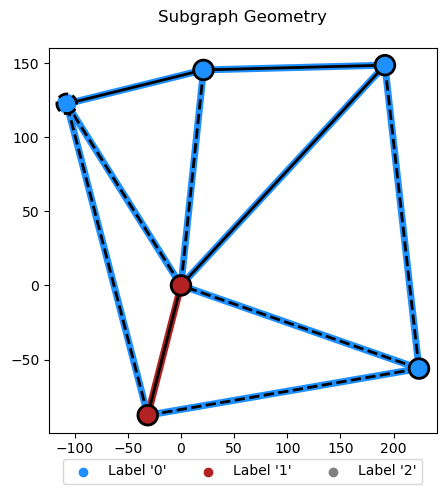

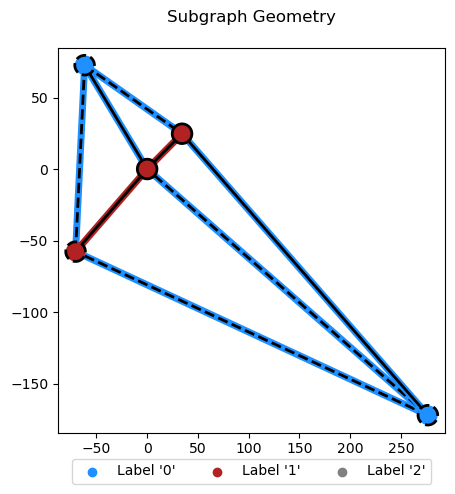

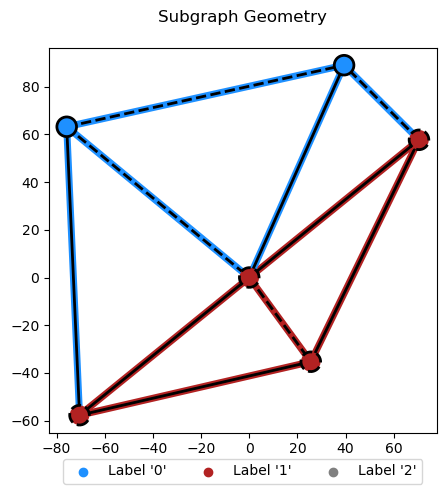

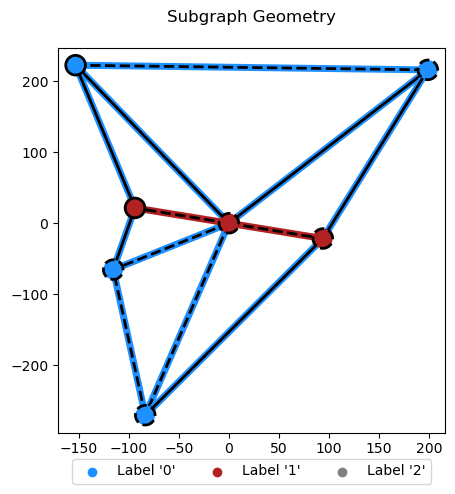

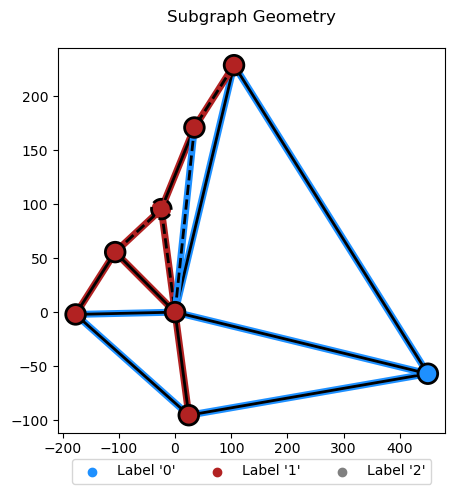

In [198]:
for sub in range(100, 200, 20):
    sub_graph = dataset[sub]
    _, ax = plt.subplots(figsize=(5, 5))
    ax = plot_subgraph_geometry(sub_graph, ax=ax)